# Fashion MNIST Classification using tf.Keras

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /Users/skhiearth/anaconda3/lib/python3.7/site-packages (1.3.0)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [17]:
# Import TensorFlow and TF Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

We use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels).

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. 

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [5]:
class_names = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat',
               'Sandal',      
               'Shirt',   
               'Sneaker',  
               'Bag',   
               'Ankle boot']

## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Caching images in memory makes training faster.
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

Number of training examples: 60000
Number of test examples:     10000


In [7]:
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

## Building the model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

This network has three layers:

* **input** `tf.keras.layers.Flatten` — This layer transforms the images from a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output** `tf.keras.layers.Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

## Training the model

In [9]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [10]:
model.fit(train_dataset, 
          epochs=50, 
          steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4941 - accuracy: 0.8270
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3783 - accuracy: 0.8634
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3377 - accuracy: 0.8783
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3102 - accuracy: 0.8853
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2981 - accuracy: 0.8894
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2772 - accuracy: 0.8974
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2706 - accuracy: 0.9007
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2577 - accuracy: 0.9043
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2468 - accuracy: 0.9077
Epoch 10/50
1875/1875 [==============================] - 3s 

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.5317 - accuracy: 0.8823
Accuracy on test dataset: 0.8823


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. 

## Predictions

In [12]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape

(32, 10)

In [13]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

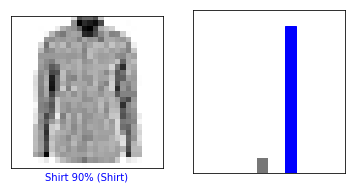

In [20]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

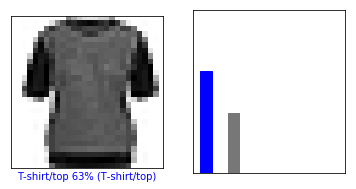

In [19]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. 

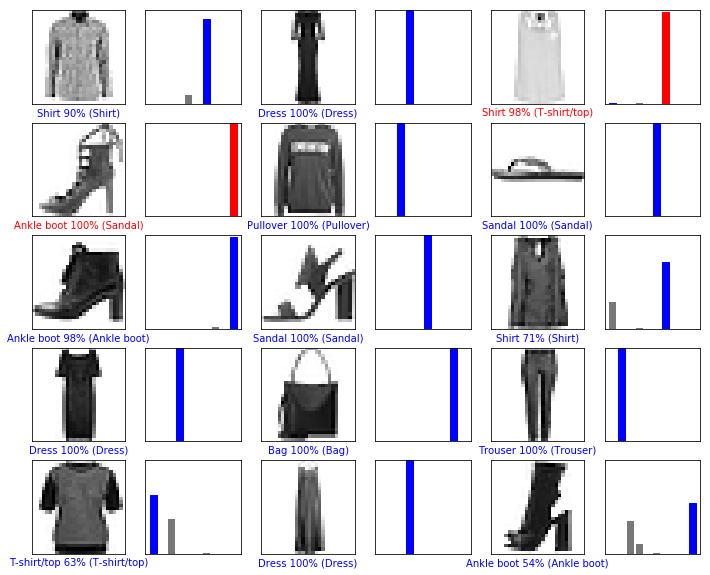

In [18]:
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)